In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

In [11]:
def softplus(x):
    return np.log(1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

In [31]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    G1 = y[0]
    G2 = y[1]
    I = y[2]

    try:
        alpha = paras['alpha'].value
        beta1 = paras['beta1'].value
        beta2 = paras['beta2'].value
        I_basal = paras['I_basal'].value
        gamma = paras['gamma'].value
        delta = paras['delta'].value
        I_max = paras['I_max'].value

    except KeyError:
        alpha, beta1, beta2, I_basal, gamma, delta, I_max = paras
    # the model equations
    dG1 = -alpha*G1
    dG2 = alpha*G1 - (beta1 + beta2 * (I+I_basal)) *G2
    dI = gamma * relu(G2 - 92.5) - delta * I
    return [dG1, dG2, dI]
    #dI = I_max * (reG2**2) / (gamma + reG2**2) - delta * I 
    #dI = I_max + gamma * relu(G2 -  92.5) - delta * I
    #dI = I_max * (G2**2) / (gamma + G2**2) - delta * I 
    #dI = I_max * G2 / (gamma + G2) - delta * I 
    #dI = gamma * G2 - delta * I


def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['G10'].value, paras['G20'].value, paras['I0'].value
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()




In [32]:
# initial conditions
G10 = 120.
G20 = 70.
I0 = 0
y0 = [G10, G20, I0]


t_values = [0, 0.5, 0.75, 1, 1.5, 2, 2.5, 3, 4, 6]
G_t_values = [70, 150, 165, 145, 90, 75, 70, 75, 80, 75]
G_t_values_dia = [100,185,210,220,195,175,105,100,90,85]

# measured data
t_measured = np.linspace(0, 9, 10)
x2_measured = np.array([0.000, 0.416, 0.489, 0.595, 0.506, 0.493, 0.458, 0.394, 0.335, 0.309])

# set parameters including bounds; you can also fix parameters (use vary=False)
# I fixed the initial concentrations, you could also set them as variables if you like (just remove the vary=False in the code below).
params = Parameters()
params.add('G10', value=G10, vary=False)
params.add('G20', value=G20, vary=False)
params.add('I0', value=I0, vary = False)
params.add('alpha', value=0.2, min=0.0001)
params.add('beta1', value=0.3, min=0.0001)
params.add('beta2', value=0.2, min=0.0001)
params.add('I_basal', value=0.3, min=5, max = 20)
params.add('gamma', value=0.2, min=0.0001)
params.add('delta', value=0.3, min=0.0001)
params.add('I_max', value=0.2, min=20)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 135
    # data points      = 10
    # variables        = 7
    chi-square         = 761.644403
    reduced chi-square = 253.881468
    Akaike info crit   = 57.3289469
    Bayesian info crit = 59.4470426
##  Warning: uncertainties could not be estimated:
    beta1:    at boundary
    I_max:    at initial value
    I_max:    at boundary
[[Variables]]
    G10:      120 (fixed)
    G20:      70 (fixed)
    I0:       0 (fixed)
    alpha:    3.31426203 (init = 0.2)
    beta1:    1.0000e-04 (init = 0.3)
    beta2:    0.00130097 (init = 0.2)
    I_basal:  5.15656012 (init = 5)
    gamma:    18.6756028 (init = 0.2)
    delta:    1.47607291 (init = 0.3)
    I_max:    20.0000000 (init = 20)


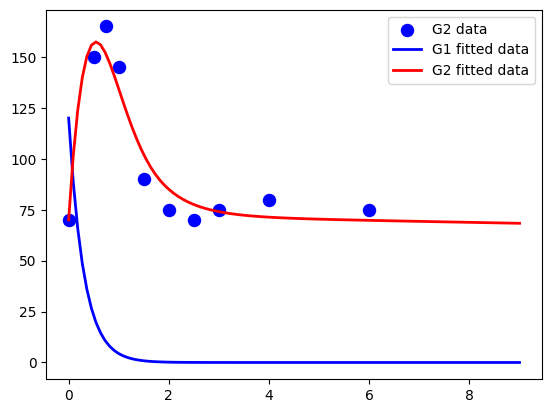

In [34]:
# fit model
result = minimize(residual, params, args=(t_values, G_t_values), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(np.linspace(0., 9., 100), y0, result.params)

# plot fitted data
plt.figure()
plt.scatter(t_values, G_t_values, marker='o', color='b', label='G2 data', s=75)

plt.plot(np.linspace(0., 9., 100), data_fitted[:, 0], '-', linewidth=2, color='blue', label='G1 fitted data')
plt.plot(np.linspace(0., 9., 100), data_fitted[:, 1], '-', linewidth=2, color='red', label='G2 fitted data')
#plt.plot(np.linspace(0., 9., 100), data_fitted[:, 2], '-', linewidth=2, color='green', label='I fitted data')
plt.legend()
#plt.xlim([0, max(t_measured)])
#plt.ylim([0, 1.1 * max(data_fitted[:, 1])])

# display fitted statistics
report_fit(result)

plt.show()